# Telecom Churn Case Study

In [539]:
# Importing Necessary Libraries.
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [540]:
# Set environment settings
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)

##Step 1: Reusable Functions

In [541]:
def calculate_metadata_matrix(input_df) :
    return pd.DataFrame({
                'Datatype' : input_df.dtypes.astype(str),
                'Non_Null_Count': input_df.count(axis = 0).astype(int),
                'Null_Count': input_df.isnull().sum().astype(int),
                'Null_Percentage': round(input_df.isnull().sum()/len(input_df) * 100 , 2),
                'Unique_Values_Count': input_df.nunique().astype(int)
                 }).sort_values(by=['Null_Percentage', 'Datatype'], ascending=[False, False])

In [542]:
def calculate_missing_percent(input_df, rowCnt):
  percent_missing_df = (input_df.isnull().sum() / input_df.isnull().count()*100).sort_values(ascending = False)
  return percent_missing_df.head(rowCnt)

In [543]:
def replace_values_na_zero(input_df, col_names):
  print('------------------------------------------------------------')
  print('PRE STATE')
  print('------------------------------------------------------------')
  print(input_df[arpu_cols].isnull().sum()*100/input_df.shape[1])
  print('------------------------------------------------------------')
  input_df[arpu_cols] = input_df[arpu_cols].fillna(0)
  print('------------------------------------------------------------')
  print('POST STATE')
  print('------------------------------------------------------------')
  print(input_df[arpu_cols].isnull().sum()*100/input_df.shape[1])
  print('------------------------------------------------------------')
  return input_df

In [544]:
def display_countplot(input_df, categoryVariable, nWidth, nHeight, nrows, ncols, rotate = False):
  plt.figure(figsize=(nWidth, nHeight))

  for index in enumerate(categoryVariable):
    #print(nrows, ncols, index[0]+1)
    plt.subplot(nrows, ncols, index[0]+1)
    sns.countplot(data = input_df, x = index[1], hue = index[1], palette='Spectral')
    if (rotate):
      plt.xticks(rotation=90)

  plt.show()

In [545]:
def display_countplotbynames(input_df, categoryVariable, nWidth, nHeight, nrows, ncols, colName, rotate = False):
  plt.figure(figsize=(nWidth, nHeight))

  for index in enumerate(categoryVariable):
    #print(nrows, ncols, index[0]+1)
    plt.subplot(nrows, ncols, index[0]+1)
    sns.countplot(data = input_df, x = index[1], hue = colName, palette='Spectral')
    if (rotate):
      plt.xticks(rotation=90)

  plt.show()

In [546]:
def display_boxplot(input_df, categoryVariable, nWidth, nHeight, nrows, ncols, colName, rotate = False):
  plt.figure(figsize=(nWidth, nHeight))

  for index in enumerate(categoryVariable):
    #print(nrows, ncols, index[0]+1)
    plt.subplot(nrows, ncols, index[0]+1)
    sns.boxplot(data = input_df, x = index[1], y = colName, hue = index[1], palette='Spectral')
    if (rotate):
      plt.xticks(rotation=90)

  plt.show()

In [547]:
def display_boxplot_y(input_df, categoryVariable, nWidth, nHeight, nrows, ncols, colName, rotate = False):
  plt.figure(figsize=(nWidth, nHeight))

  for index in enumerate(categoryVariable):
    #print(nrows, ncols, index[0]+1)
    plt.subplot(nrows, ncols, index[0]+1)
    sns.boxplot(data = input_df, x = colName, y = index[1], hue = colName, palette='Spectral')
    if (rotate):
      plt.xticks(rotation=90)

  plt.show()

In [548]:
def display_bar_graph(title, month, y_list, data):
    plt.figure(figsize=(15, 10))

    for i, m in enumerate(month):
        plt.subplot(2, 3, i+1)
        plt.title(f'{title} for {m}')
        sns.barplot(x='churn_probability', y=y_list[i], data=data, palette='Spectral')

    plt.tight_layout()
    plt.show()

##Step 2: Loading Data

In [549]:
# Reading Dataset into a DataFrame.
telecom_df = pd.read_csv('/content/train.csv')
telecom_test_df = pd.read_csv('/content/test.csv')
telecom_sample_df = pd.read_csv('/content/sample.csv')

In [550]:
#Read Top 5 rows
telecom_df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [551]:
#find information of dataframe shape
telecom_df.shape

(69999, 172)

In [552]:
#Print full summary hence verbose has been set to 1
telecom_df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [553]:
#Description of Dataframe data in transposed format so that values are readable
telecom_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,69999.0,34999.000000,20207.115084,0.000,17499.5000,34999.000,52498.5000,69998.000
circle_id,69999.0,109.000000,0.000000,109.000,109.0000,109.000,109.0000,109.000
loc_og_t2o_mou,69297.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000
std_og_t2o_mou,69297.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000
loc_ic_t2o_mou,69297.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000
arpu_6,69999.0,283.134365,334.213918,-2258.709,93.5810,197.484,370.7910,27731.088
arpu_7,69999.0,278.185912,344.366927,-1289.715,86.7140,191.588,365.3695,35145.834
arpu_8,69999.0,278.858826,351.924315,-945.808,84.0950,192.234,369.9090,33543.624
onnet_mou_6,67231.0,133.153275,299.963093,0.000,7.4100,34.110,119.3900,7376.710
onnet_mou_7,67312.0,133.894438,311.277193,0.000,6.6750,32.280,115.8375,8157.780


In [554]:
#Print columns metadata
telecom_meta_df = calculate_metadata_matrix(telecom_df)
telecom_meta_df

,Datatype,Non_Null_Count,Null_Count,Null_Percentage,Unique_Values_Count
date_of_last_rech_data_6,object,17568,52431,74.90,30
total_rech_data_6,float64,17568,52431,74.90,36
max_rech_data_6,float64,17568,52431,74.90,47
count_rech_2g_6,float64,17568,52431,74.90,30
count_rech_3g_6,float64,17568,52431,74.90,23
av_rech_amt_data_6,float64,17568,52431,74.90,792
arpu_3g_6,float64,17568,52431,74.90,5506
arpu_2g_6,float64,17568,52431,74.90,5389
night_pck_user_6,float64,17568,52431,74.90,2
fb_user_6,float64,17568,52431,74.90,2


##Step 3: Data Cleansing

###Step 3.1: Finding columns having single value

In [555]:
telecom_meta_df[telecom_meta_df['Unique_Values_Count'] == 1]

,Datatype,Non_Null_Count,Null_Count,Null_Percentage,Unique_Values_Count
std_og_t2c_mou_8,float64,66296,3703,5.29,1
std_ic_t2o_mou_8,float64,66296,3703,5.29,1
std_og_t2c_mou_6,float64,67231,2768,3.95,1
std_ic_t2o_mou_6,float64,67231,2768,3.95,1
std_og_t2c_mou_7,float64,67312,2687,3.84,1
std_ic_t2o_mou_7,float64,67312,2687,3.84,1
last_date_of_month_8,object,69266,733,1.05,1
loc_og_t2o_mou,float64,69297,702,1.00,1
std_og_t2o_mou,float64,69297,702,1.00,1
loc_ic_t2o_mou,float64,69297,702,1.00,1


In [556]:
#Finding columns having single value
single_val_cols_df = []

for col in telecom_df.columns:
    if telecom_df[col].nunique() == 1:
        single_val_cols_df.append(col)

print(single_val_cols_df)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [557]:
# Based on the dataset, we remove these columns from the training set
telecom_df.drop(single_val_cols_df, axis=1, inplace=True)

# Based on the dataset, we remove these columns from the test set
telecom_test_df.drop(single_val_cols_df, axis=1, inplace=True)

###Step 3.2: Missing values

In [558]:
telecom_meta_df[telecom_meta_df['Null_Percentage'] >= 70]

,Datatype,Non_Null_Count,Null_Count,Null_Percentage,Unique_Values_Count
date_of_last_rech_data_6,object,17568,52431,74.90,30
total_rech_data_6,float64,17568,52431,74.90,36
max_rech_data_6,float64,17568,52431,74.90,47
count_rech_2g_6,float64,17568,52431,74.90,30
count_rech_3g_6,float64,17568,52431,74.90,23
av_rech_amt_data_6,float64,17568,52431,74.90,792
arpu_3g_6,float64,17568,52431,74.90,5506
arpu_2g_6,float64,17568,52431,74.90,5389
night_pck_user_6,float64,17568,52431,74.90,2
fb_user_6,float64,17568,52431,74.90,2


In [559]:
#As we have recharge amount these columns will not make sense and hence we can drop
date_cols = ['date_of_last_rech_6',
            'date_of_last_rech_7',
            'date_of_last_rech_8',
            'date_of_last_rech_data_6',
            'date_of_last_rech_data_7',
            'date_of_last_rech_data_8',
            ]

In [560]:
# Based on the dataset, we remove these columns from the training set
telecom_df.drop(date_cols, axis=1, inplace=True)

# Based on the dataset, we remove these columns from the test set
telecom_test_df.drop(date_cols, axis=1, inplace=True)

####Step 3.2.1: ARPU(Average Revenue Per user) columns

In [561]:
arpu_cols = telecom_df.columns[telecom_df.columns.str.contains('arpu_')]
arpu_cols

Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')

In [562]:
# Replacing NaN values in ARPU related columns with 0 in the training set
telecom_df = replace_values_na_zero(telecom_df, arpu_cols)

------------------------------------------------------------
PRE STATE
------------------------------------------------------------
arpu_6           0.000000
arpu_7           0.000000
arpu_8           0.000000
arpu_3g_6    34268.627451
arpu_3g_7    34074.509804
arpu_3g_8    33713.725490
arpu_2g_6    34268.627451
arpu_2g_7    34074.509804
arpu_2g_8    33713.725490
dtype: float64
------------------------------------------------------------
------------------------------------------------------------
POST STATE
------------------------------------------------------------
arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64
------------------------------------------------------------


In [563]:
# Replacing NaN values in ARPU related columns with 0 in the training set
telecom_test_df = replace_values_na_zero(telecom_test_df, arpu_cols)

------------------------------------------------------------
PRE STATE
------------------------------------------------------------
arpu_6           0.000000
arpu_7           0.000000
arpu_8           0.000000
arpu_3g_6    14746.710526
arpu_3g_7    14667.105263
arpu_3g_8    14525.000000
arpu_2g_6    14746.710526
arpu_2g_7    14667.105263
arpu_2g_8    14525.000000
dtype: float64
------------------------------------------------------------
------------------------------------------------------------
POST STATE
------------------------------------------------------------
arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64
------------------------------------------------------------


#### Step 3.2.2: Recharge Columns

In [564]:
recharge_cols = telecom_df.columns[telecom_df.columns.str.contains('_rech_')]
recharge_cols

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')

In [565]:
# Replacing NaN values in recharge related columns with 0 in the training set
telecom_df = replace_values_na_zero(telecom_df, recharge_cols)

------------------------------------------------------------
PRE STATE
------------------------------------------------------------
arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64
------------------------------------------------------------
------------------------------------------------------------
POST STATE
------------------------------------------------------------
arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64
------------------------------------------------------------


In [566]:
# Replacing NaN values in recharge related columns with 0 in the test set
telecom_test_df = replace_values_na_zero(telecom_test_df, recharge_cols)

------------------------------------------------------------
PRE STATE
------------------------------------------------------------
arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64
------------------------------------------------------------
------------------------------------------------------------
POST STATE
------------------------------------------------------------
arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64
------------------------------------------------------------


### Step 3.3: New Features

In [567]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the telecom_dfing set
telecom_df['total_rech_data_amt_6'] = telecom_df['total_rech_data_6'] * telecom_df['av_rech_amt_data_6']
telecom_df['total_rech_data_amt_7'] = telecom_df['total_rech_data_7'] * telecom_df['av_rech_amt_data_7']

telecom_df['total_amt_6'] = telecom_df['total_rech_data_amt_6'] + telecom_df['total_rech_amt_6']
telecom_df['total_amt_7'] = telecom_df['total_rech_data_amt_7'] + telecom_df['total_rech_amt_7']

telecom_df['total_avg_amt_6_7'] = telecom_df[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [568]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the test set
telecom_test_df['total_rech_data_amt_6'] = telecom_test_df['total_rech_data_6'] * telecom_test_df['av_rech_amt_data_6']
telecom_test_df['total_rech_data_amt_7'] = telecom_test_df['total_rech_data_7'] * telecom_test_df['av_rech_amt_data_7']

telecom_test_df['total_amt_6'] = telecom_test_df['total_rech_data_amt_6'] + telecom_test_df['total_rech_amt_6']
telecom_test_df['total_amt_7'] = telecom_test_df['total_rech_data_amt_7'] + telecom_test_df['total_rech_amt_7']

telecom_test_df['total_avg_amt_6_7'] = telecom_test_df[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [569]:
# Dropping the columns as they are not so useful columns for high value customer or churn

drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
                  'av_rech_amt_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',]

telecom_df.drop(drop_data_cols, axis=1, inplace=True)

# Dropping the drop_data_cols from the test set
telecom_test_df.drop(drop_data_cols, axis=1, inplace=True)

In [570]:
# Checking for any null value in the derived column in the training set
telecom_df['total_avg_amt_6_7'].isnull().sum()
telecom_test_df['total_avg_amt_6_7'].isnull().sum()

20310

In [571]:
# Finding cutoff value for only top 70% of high value customers
cutoff = telecom_df['total_avg_amt_6_7'].quantile(0.7)
cutoff

1029.8999999999996

In [572]:
# Filter high value customers in the new dataframe (high_val_train) where total recharge is more than 477.5
telecom_highval_df = telecom_df[(telecom_df['total_avg_amt_6_7'] > cutoff)].copy()

telecom_highval_df.shape

(6737, 150)

In [573]:
telecom_highval_df['churn_probability'] = telecom_highval_df['churn_probability'].astype('category')
telecom_highval_df['churn_probability'].dtype

CategoricalDtype(categories=[0, 1], ordered=False)

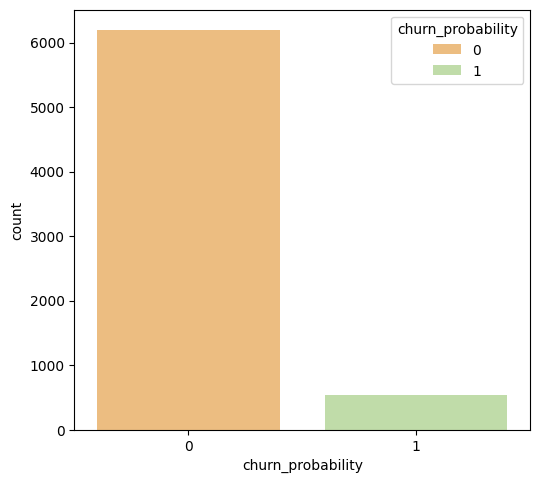

In [574]:
vars_cat = ['churn_probability']
display_countplot(telecom_highval_df, vars_cat, 20, 12, 2, 3)

In [575]:
# Convert AON in month format
print(telecom_highval_df['aon'])
telecom_highval_df['aon_months'] = (telecom_highval_df['aon'] / 30).round(0)
telecom_highval_df.drop('aon', axis=1, inplace=True)
telecom_highval_df['aon_months'].head()

4         647
27        573
45        942
53       1194
54        730
         ... 
69980     773
69982    1577
69984     283
69993    1507
69994     221
Name: aon, Length: 6737, dtype: int64


4     22.0
27    19.0
45    31.0
53    40.0
54    24.0
Name: aon_months, dtype: float64

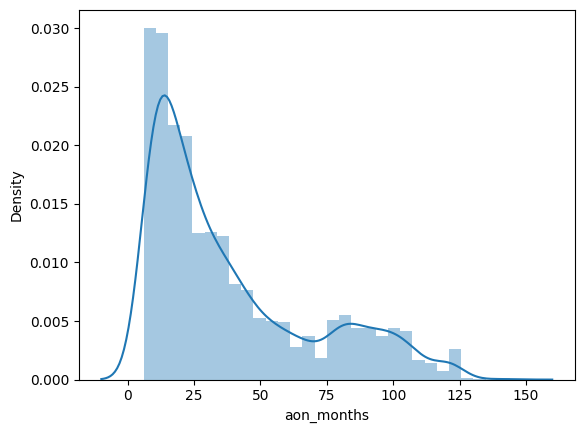

In [576]:
# Checking the distribution of he tenure variable
sns.distplot(telecom_highval_df['aon_months'],bins=30)
plt.show()

In [577]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = ['0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom_highval_df['aon_buckets'] = pd.cut(telecom_highval_df['aon_months'], tn_range, labels = tn_label)
telecom_df.head()
#telecom_highval_df['aon_buckets'].head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_amt_6,total_amt_7,total_avg_amt_6_7
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0,NaN,NaN,NaN
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,0,0,0,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,0.0,352.91,0.00,0.0,3.96,0.0,0.0,122.07,0.0,0.0,122.08,0.0,NaN,0.0,NaN,0,0,0,0,0,0,0,1,0,0,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0,NaN,290.0,290.0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,28.94,84.99,0.00,0.0,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.0,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,70,50,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.

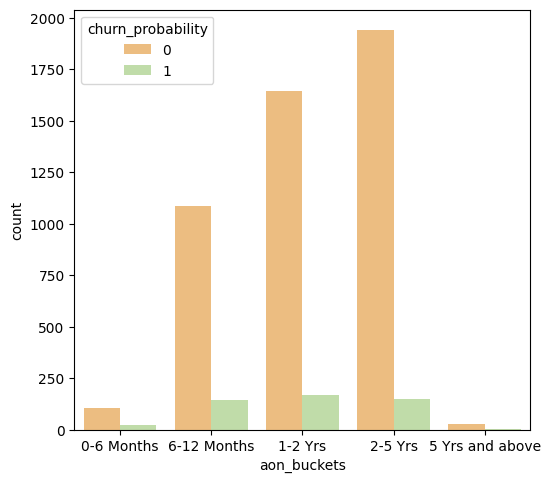

In [578]:
# Plotting a bar plot for tenure range
vars_cat = ['aon_buckets']
display_countplotbynames(telecom_highval_df, vars_cat, 20, 12, 2, 3, 'churn_probability')

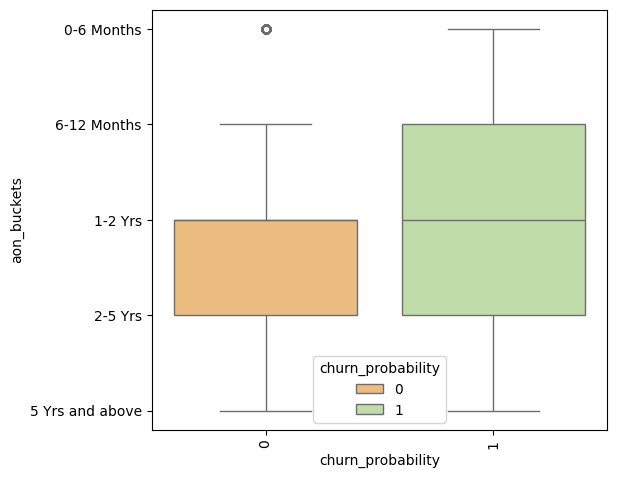

In [579]:
# Boxplot for categorical variables to see demands
vars_cat = ['aon_buckets']
display_boxplot_y(telecom_highval_df, vars_cat, 20, 12, 2, 3,'churn_probability', True)

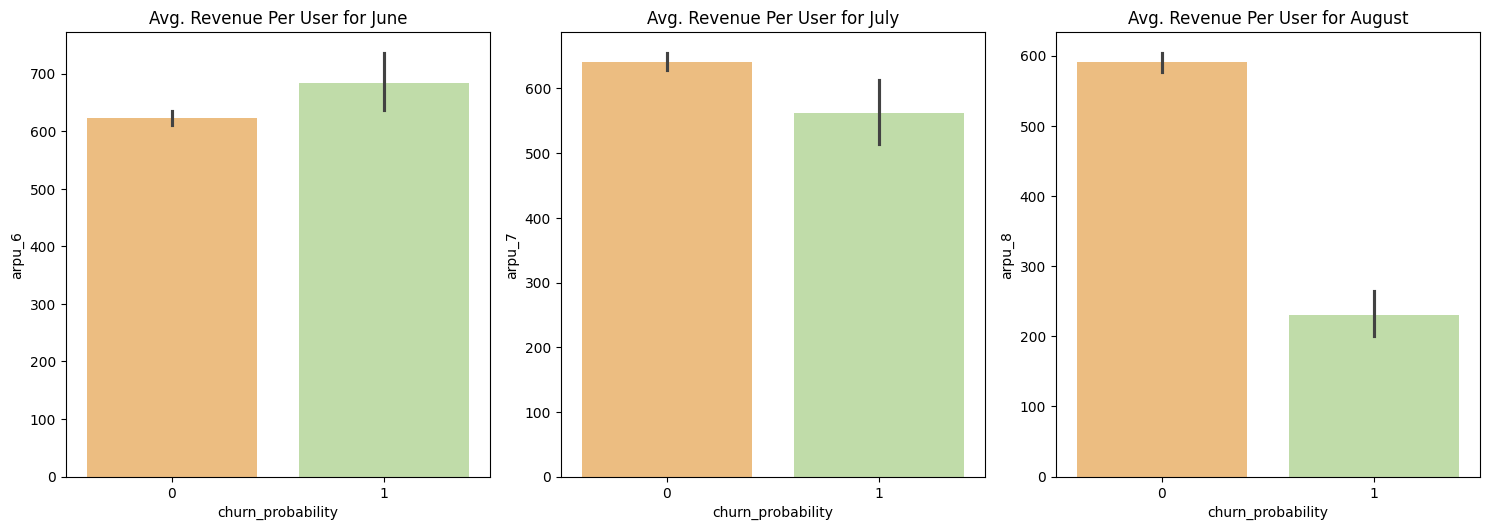

In [580]:
# Visualising Average Revenue per user
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
display_bar_graph('Avg. Revenue Per User', ['June', 'July', 'August'], arpu_cols, telecom_highval_df)

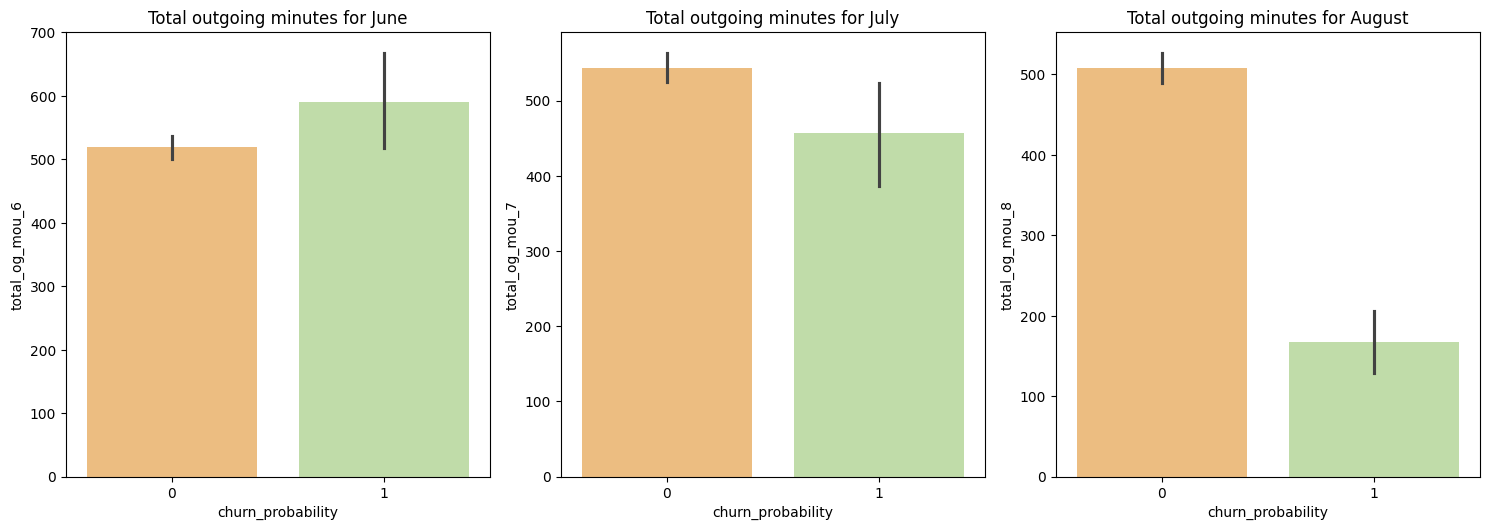

In [581]:
# Visualising Outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
display_bar_graph('Total outgoing minutes', ['June', 'July', 'August'], total_og_mou_cols, telecom_highval_df)

### Step 3.4: Missing values using KNN

In [582]:
# Create imputer instance
imputer = KNNImputer(n_neighbors=5)

In [583]:
# Create a copy of telecom_highval_df df and use the new df (telecom_churn_df) for pruning in the training set
telecom_churn_df = telecom_highval_df.copy()
telecom_churn_df.reset_index(inplace=True)
telecom_churn_df.drop(['index'], axis=1, inplace=True)

In [584]:
telecom_churn_df.shape

(6737, 151)

In [585]:
# Get the list of columns with missing values in the training set
telecom_churn_num_df = telecom_churn_df.select_dtypes(include=['int64','float64'])
numerical_cols = list(telecom_churn_df.columns)

mv = round(100*(telecom_churn_num_df.isnull().sum(axis=0)/telecom_churn_num_df.shape[0]), 2)
s = mv.loc[mv>0]
impute_numerical_cols = list(s.index)
len(impute_numerical_cols)

98

In [586]:
telecom_num_df = telecom_churn_df[impute_numerical_cols]
telecom_churn_num_df = telecom_churn_df.drop(impute_numerical_cols, axis=1)

In [587]:
churn_num_df = telecom_churn_num_df.select_dtypes(include=['int64','float64'])
churn_num_cols = list(churn_num_df.columns)
telecom_churn_num_df = telecom_churn_num_df[churn_num_cols]

In [588]:
%%time
# Impute using KNN imputer instance
telecom_imp_df = imputer.fit_transform(telecom_num_df)

CPU times: user 10.3 s, sys: 845 ms, total: 11.2 s
Wall time: 11.1 s


In [589]:
# Convert it to df post imputation
telecom_imp_df = pd.DataFrame(telecom_imp_df, columns=impute_numerical_cols)
telecom_imp_df.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,total_amt_6,total_amt_7
0,21.28,4.830,6.13,56.99,38.110,9.63,53.64,0.00,0.0,15.73,0.00,0.0,10.16,4.830,6.13,36.74,19.880,4.61,11.99,1.23,5.01,0.00,9.85,0.00,58.91,25.94,15.76,0.00,0.00,0.00,4.35,0.00,0.00,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.000,0.0,0.00,17.000,0.00,0.00,0.0,0.0,5.44,1.390,2.66,10.58,4.330,19.49,5.51,3.630,6.14,21.54,9.360,28.31,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,25.0,41.0,25.0,7.0,6.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1515.0,1473.0
1,8.58,11.480,12.68,133.16,158.730,182.83,0.00,0.00,0.0,0.00,0.00,0.0,8.58,11.480,12.68,96.91,149.440,157.23,33.71,9.28,25.59,0.00,0.00,0.00,139.21,170.21,195.51,0.00,0.00,0.00,2.53,0.00,0.00,0.0,0.0,0.0,2.53,0.00,0.00,0.0,0.000,0.0,0.00,0.000,0.00,0.00,0.0,0.0,51.74,83.830,82.81,129.01,214.490,159.69,87.28,67.690,107.94,268.04,366.030,350.46,0.00,0.000,0.40,0.00,0.000,0.00,15.43,0.000,0.0,15.43,0.000,0.40,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,154.0,152.0,164.0,4.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1385.0,1180.0
2,872.16,546.060,1078.93,410.56,420.190,225.53,8.83,149.04,0.0,6.43,388.73,0.0,75.24,62.190,69.71,167.34,162.360,165.78,0.00,2.35,1.18,2.44,0.25,0.18,242.59,226.91,236.68,791.49,221.51,1009.21,232.68,99.08,28.79,0.0,0.0,0.0,1024.18,320.59,1038.01,0.0,0.000,0.0,17.49,36.410,33.16,3.78,0.0,0.0,36.96,128.290,69.49,490.64,223.730,203.76,0.00,1.600,0.66,527.61,353.630,273.93,5.11,9.490,4.16,41.31,90.010,101.68,0.00,0.000,0.0,46.43,99.510,105.84,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,41.0,46.0,41.0,0.0,1.0,0.0,3.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2137.0,3126.0
3,104.84,170.210,122.41,149.78,409.390,439.81,0.00,0.00,0.0,0.00,0.00,0.0,104.84,168.510,122.41,149.78,368.860,438.54,0.00,0.63,0.00,0.00,0.00,0.00,254.63,538.01,560.96,0.00,1.70,0.00,0.00,39.90,1.26,0.0,0.0,0.0,0.00,41.60,1.26,0.0,0.000,0.0,0.00,0.000,0.00,2.28,0.0,0.0,104.66,123.240,108.13,165.71,266.460,365.76,5.46,1.230,0.71,275.84,390.940,474.61,0.00,4.380,7.49,0.00,2.480,8.23,0.00,0.000,0.0,0.00,6.860,15.73,0.0,0.0,0.0,0.0,0.110,0.0,0.0,0.0,0.0,198.0,198.0,198.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1578.0,1828.0
4,0.80,0.274,0.00,0.00,2.524,0.55,0.00,0.66,0.0,0.00,0.00,0.0,0.80,0.274,0.00,0.00,0.936,0.55,0.00,0.00,0.00,0.00,0.00,0.00,0.80,1.21,0.55,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.116,0.0,4.63,1.834,0.00,1.43,0.0,0.0,0.78,9.064,0.00,3.14,35.394,0.45,0.46,4.132,0.00,4.39,48.594,0.45,0.00,1.758,0.00,0.00,0.296,0.00,0.00,0.246,0.0,0.00,2.302,0.00,0.0,0.0,0.0,0.0,0.072,0.0,0.0,0.0,0.0,25.0,17.0,63.6,10.

In [590]:
# Merge the two dataframes together post imputation to create the final training set
telecom_final_df = pd.concat([telecom_imp_df, telecom_churn_num_df], join='inner', axis=1)
telecom_final_df.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,total_amt_6,total_amt_7,id,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_avg_amt_6_7,aon_months
0,21.28,4.830,6.13,56.99,38.110,9.63,53.64,0.00,0.0,15.73,0.00,0.0,10.16,4.830,6.13,36.74,19.880,4.61,11.99,1.23,5.01,0.00,9.85,0.00,58.91,25.94,15.76,0.00,0.00,0.00,4.35,0.00,0.00,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.000,0.0,0.00,17.000,0.00,0.00,0.0,0.0,5.44,1.390,2.66,10.58,4.330,19.49,5.51,3.630,6.14,21.54,9.360,28.31,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.000,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,25.0,41.0,25.0,7.0,6.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1515.0,1473.0,4,240.708,128.191,101.565,63.26,42.94,15.76,21.54,9.36,28.31,13,10,8,290,136,122,50,41,30,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0.00,35.00,0.00,0.00,35.12,0.00,0,0,0,7,6,6,0,0,0,0,1,0,0.00,0.00,0.00,1494.0,22.0
1,8.58,11.480,12.68,133.16,158.730,182.83,0.00,0.00,0.0,0.00,0.00,0.0,8.58,11.480,12.68,96.91,149.440,157.23,33.71,9.28,25.59,0.00,0.00,0.00,139.21,170.21,195.51,0.00,0.00,0.00,2.53,0.00,0.00,0.0,0.0,0.0,2.53,0.00,0.00,0.0,0.000,0.0,0.00,0.000,0.00,0.00,0.0,0.0,51.74,83.830,82.81,129.01,214.490,159.69,87.28,67.690,107.94,268.04,366.030,350.46,0.00,0.000,0.40,0.00,0.000,0.00,15.43,0.000,0.0,15.43,0.000,0.40,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,154.0,152.0,164.0,4.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1385.0,1180.0,27,390.489,350.985,421.300,141.74,170.21,195.51,283.48,366.03,350.86,13,8,4,565,572,250,154,200,164,110,200,61,5.99,92.93,10.54,374.70,275.38,1342.93,79.35,86.55,161.92,0.18,69.20,161.92,1,0,0,3,1,1,0,0,1,0,1,1,700.40,185.71,173.72,1282.5,19.0
2,872.16,546.060,1078.93,410.56,420.190,225.53,8.83,149.04,0.0,6.43,388.73,0.0,75.24,62.190,69.71,167.34,162.360,165.78,0.00,2.35,1.18,2.44,0.25,0.18,242.59,226.91,236.68,791.49,221.51,1009.21,232.68,99.08,28.79,0.0,0.0,0.0,1024.18,320.59,1038.01,0.0,0.000,0.0,17.49,36.410,33.16,3.78,0.0,0.0,36.96,128.290,69.49,490.64,223.730,203.76,0.00,1.600,0.66,527.61,353.630,273.93,5.11,9.490,4.16,41.31

In [591]:
telecom_final_df.shape

(6737, 149)

In [592]:
# Verify no missing value is present in the training set now
telecom_final_df.isnull().sum().sort_values(ascending=False)

onnet_mou_6           0
fb_user_7             0
total_amt_6           0
total_amt_7           0
id                    0
arpu_6                0
arpu_7                0
arpu_8                0
total_og_mou_6        0
total_og_mou_7        0
total_og_mou_8        0
total_ic_mou_6        0
total_ic_mou_7        0
total_ic_mou_8        0
total_rech_num_6      0
total_rech_num_7      0
total_rech_num_8      0
fb_user_8             0
fb_user_6             0
isd_ic_mou_6          0
night_pck_user_8      0
isd_ic_mou_8          0
ic_others_6           0
ic_others_7           0
ic_others_8           0
max_rech_data_6       0
max_rech_data_7       0
max_rech_data_8       0
count_rech_2g_6       0
count_rech_2g_7       0
count_rech_2g_8       0
count_rech_3g_6       0
count_rech_3g_7       0
count_rech_3g_8       0
night_pck_user_6      0
night_pck_user_7      0
total_rech_amt_6      0
total_rech_amt_7      0
total_rech_amt_8      0
max_rech_amt_6        0
monthly_2g_7          0
monthly_2g_8    

In [593]:
#Try

There are no missing values in the dataset now.